Project imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import glob

from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

Loading dataset

In [ ]:
# load flower dataset from tensorflow datasets
dataset, datasetInfo = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)

# setup the data splits
trainSet = dataset['test']
testSet = dataset['train']
validationSet = dataset['validation']

In [ ]:
# display number of images in each split
print("Training set size: " + str(len(trainSet)))
print("Test set size: " + str(len(testSet)))
print("Validation set size: " + str(len(validationSet)))
numClasses = datasetInfo.features['label'].num_classes
print('Total Number of Classes: {}'.format(numClasses))

Training set size: 6149
Test set size: 1020
Validation set size: 1020
Total Number of Classes: 102


In [ ]:
# dictionary that holds all label pairings
classLabels = {"20": "fire lily", "2": "canterbury bells", "44": "bolero deep blue",
        "0": "pink primrose", "33": "mexican aster", "26": "prince of wales feathers",
        "6": "moon orchid", "15": "globe-flower", "24": "grape hyacinth",
        "25": "corn poppy", "78": "toad lily", "38": "siam tulip", "23": "red ginger",
        "66": "spring crocus", "34": "alpine sea holly", "31": "garden phlox",
        "9": "globe thistle", "5": "tiger lily", "92": "ball moss",
        "32": "love in the mist", "8": "monkshood", "101": "blackberry lily",
        "13": "spear thistle", "18": "balloon flower", "99": "blanket flower",
        "12": "king protea", "48": "oxeye daisy", "14": "yellow iris",
        "60": "cautleya spicata", "30": "carnation", "63": "silverbush",
        "67": "bearded iris", "62": "black-eyed susan", "68": "windflower",
        "61": "japanese anemone", "19": "giant white arum lily",
        "37": "great masterwort", "3": "sweet pea", "85": "tree mallow",
        "100": "trumpet creeper", "41": "daffodil", "21": "pincushion flower",
        "1": "hard-leaved pocket orchid", "53": "sunflower",
        "65": "osteospermum", "69": "tree poppy", "84": "desert-rose",
        "98": "bromelia", "86": "magnolia", "4": "english marigold",
        "91": "bee balm", "27": "stemless gentian", "96": "mallow",
        "56": "gaura", "39": "lenten rose", "46": "marigold",
        "58": "orange dahlia", "47": "buttercup", "54": "pelargonium",
        "35": "ruby-lipped cattleya", "90": "hippeastrum",
        "28": "artichoke", "70": "gazania", "89": "canna lily",
        "17": "peruvian lily", "97": "mexican petunia", "7": "bird of paradise",
        "29": "sweet william", "16": "purple coneflower", "51": "wild pansy",
        "83": "columbine", "11": "colt's foot", "10": "snapdragon",
        "95": "camellia", "22": "fritillary", "49": "common dandelion",
        "43": "poinsettia", "52": "primula", "71": "azalea",
        "64": "californian poppy", "79": "anthurium", "75": "morning glory",
        "36": "cape flower", "55": "bishop of llandaff", "59": "pink-yellow dahlia",
        "81": "clematis", "57": "geranium", "74": "thorn apple",
        "40": "barbeton daisy", "94": "bougainvillea", "42": "sword lily",
        "82": "hibiscus", "77": "lotus lotus", "87": "cyclamen", "93": "foxglove",
        "80": "frangipani", "73": "rose", "88": "watercress", "72": "water lily",
        "45": "wallflower", "76": "passion flower", "50": "petunia"}

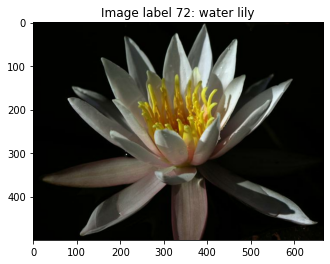


Exmaple of data augmentation


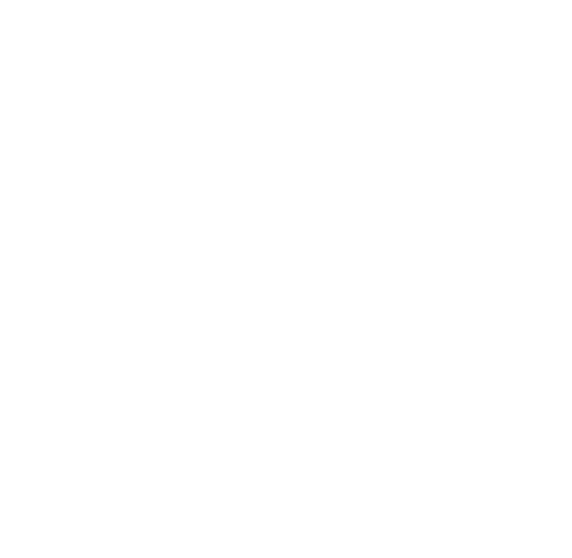

In [ ]:
# display an image from the dataset
for image, label in testSet.take(1):
  image = image.numpy()
  plt.figure()
  plt.imshow(image, cmap=None)
  plt.title('Image label ' + format(label) + ': ' + format(classLabels[str(label.numpy())]))
  plt.show()

# create a pipelinie for data augmentation
dataAugmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
])

# display the same image again but with the variations from data augmentation
print("\nExmaple of data augmentation")
for image, label in testSet.take(1):
  plt.figure(figsize=(10, 10))
  image = image.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmentedImage = dataAugmentation(tf.expand_dims(image, 0))
    #plt.imshow(augmentedImage[0] / 255)
    plt.axis('off')

Image pre-processing pipeline

In [ ]:
imageSize = 224
batchSize = 32

# function to resize the image to be 224 x 224
# also, rgb values need to be standardised to be in the range 0-1, as opposed
# to 0-255
def resizeImage(image, label):
  image = tf.image.resize(image, (imageSize, imageSize))/255.
  return image, label

# create batches of training, testing and validation images,
# pre-processing is applied to all the images
# cache() and prefetch() is used to optimise file reading for training
trainBatches = trainSet.cache().shuffle(len(trainSet)//4).map(resizeImage).batch(batchSize).prefetch(1)
testBatches = testSet.cache().map(resizeImage).batch(batchSize).prefetch(1)
validationBatches = validationSet.cache().map(resizeImage).batch(batchSize).prefetch(1)

Creating models

In [ ]:
# creation of custom model as described in dissertation
# consisting of three convolutional blocks
# data augmentation and dropout has been added to tackle overfitting
customModel = tf.keras.Sequential(name="CustomModel")
customModel.add(dataAugmentation)
customModel.add(tf.keras.layers.Conv2D(16, 3, input_shape=(224, 224, 3), padding="same", activation='relu', name="Conv1"))
customModel.add(tf.keras.layers.MaxPooling2D(name="MaxPool1"))
customModel.add(tf.keras.layers.Conv2D(16, 3, padding="same", activation='relu', name="Conv2"))
customModel.add(tf.keras.layers.MaxPooling2D(name="MaxPool2"))
customModel.add(tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu', name="Conv3"))
customModel.add(tf.keras.layers.MaxPooling2D(name="MaxPool3"))
customModel.add(tf.keras.layers.Dropout(0.5, name="Dropout1"))
customModel.add(tf.keras.layers.Flatten(name="Flatten"))
customModel.add(tf.keras.layers.Dense(numClasses, activation='softmax', name="Dense1"))
customModel.summary()


# loading pre trained model for transfer learning to be used as a feature extractor
preTrainedModelURL = "https://tfhub.dev/google/experts/bit/r50x1/in21k/flower/1" # resNet model
featureExtractor = hub.KerasLayer(preTrainedModelURL, input_shape=(imageSize, imageSize, 3), trainable=False, name="FeatureExtractor")

# creation of model with transfer learning included
transferLearningModel = tf.keras.Sequential(name="TransferLearningModel")
transferLearningModel.add(dataAugmentation)
transferLearningModel.add(featureExtractor)
transferLearningModel.add(tf.keras.layers.Dense(numClasses, activation='softmax', name="Dense1"))
transferLearningModel.summary()

Model: "CustomModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 Conv1 (Conv2D)              (None, 224, 224, 16)      448       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 112, 112, 16)      0         
                                                                 
 Conv2 (Conv2D)              (None, 112, 112, 16)      2320      
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 56, 56, 16)        0         
                                                                 
 Conv3 (Conv2D)              (None, 56, 56, 32)        4640      
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 28, 28, 32)        

Training models

In [ ]:
# compile the models
#customModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transferLearningModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# number of times to train on whole dataset 200 normally
epochs = 12

# parameter used to stop the model from training when its validation accuracy is no longer increasing
#earlyStoppingCustom = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, mode='max')
earlyStoppingTransfer = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, mode='max')

# begin training and start tracking training statistics
print("Starting training for custom model")
#customModelHistory = customModel.fit(trainBatches, epochs=epochs, validation_data=validationBatches, callbacks=[earlyStoppingCustom])

print("\nStarting training for transfer learning model")
transferLearningModelHistory = transferLearningModel.fit(trainBatches, epochs=epochs, validation_data=validationBatches, callbacks=[earlyStoppingTransfer])

Starting training for custom model

Starting training for transfer learning model
Epoch 1/12
193/193 [==============================] - 109s 532ms/step - loss: 0.0631 - accuracy: 0.9891 - val_loss: 0.1748 - val_accuracy: 0.9784
Epoch 2/12
193/193 [==============================] - 101s 526ms/step - loss: 0.0634 - accuracy: 0.9862 - val_loss: 0.1531 - val_accuracy: 0.9853
Epoch 3/12
193/193 [==============================] - 101s 523ms/step - loss: 0.0570 - accuracy: 0.9907 - val_loss: 0.1748 - val_accuracy: 0.9814
Epoch 4/12
193/193 [==============================] - 102s 527ms/step - loss: 0.0972 - accuracy: 0.9868 - val_loss: 0.1585 - val_accuracy: 0.9853
Epoch 5/12
193/193 [==============================] - 102s 526ms/step - loss: 0.0368 - accuracy: 0.9937 - val_loss: 0.1804 - val_accuracy: 0.9843
Epoch 6/12
193/193 [==============================] - 101s 525ms/step - loss: 0.0585 - accuracy: 0.9894 - val_loss: 0.1677 - val_accuracy: 0.9873
Epoch 7/12
193/193 [======================

Training statistics

In [ ]:
# take training statistics from custom model, and display them
#accuracy = customModelHistory.history['accuracy']
#valAccuracy = customModelHistory.history['val_accuracy']
#loss = customModelHistory.history['loss']
#valLoss =  customModelHistory.history['val_loss']
#epochs = earlyStoppingCustom.stopped_epoch + 1

#plt.figure(figsize=(8,8))
#plt.subplot(1,2,1)
#plt.title("Training and Validation Accuracy")
#plt.plot(range(epochs), accuracy, label="Training Accuracy")
#plt.plot(range(epochs), valAccuracy, label="Validation Accuracy")
#plt.legend(loc="lower right")

#plt.subplot(1,2,2)
#plt.title("Training and Validation Loss")
#plt.plot(range(epochs), loss, label="Training Loss")
#plt.plot(range(epochs), valLoss, label="Validation Loss")
#plt.legend(loc="upper right")
#plt.show()

# take training statistics from transfer learning model, and display them
#accuracy = transferLearningModelHistory.history['accuracy']
#valAccuracy = transferLearningModelHistory.history['val_accuracy']
#loss = transferLearningModelHistory.history['loss']
#valLoss =  transferLearningModelHistory.history['val_loss']
#epochs = earlyStoppingTransfer.stopped_epoch + 1

#plt.figure(figsize=(8,8))
#plt.subplot(1,2,1)
#plt.title("Training and Validation Accuracy")
#plt.plot(range(epochs), accuracy, label="Training Accuracy")
#plt.plot(range(epochs), valAccuracy, label="Validation Accuracy")
#plt.legend(loc="lower right")

#plt.subplot(1,2,2)
#plt.title("Training and Validation Loss")
#plt.plot(range(epochs), loss, label="Training Loss")
#plt.plot(range(epochs), valLoss, label="Validation Loss")
#plt.legend(loc="upper right")
#plt.show()

Saving and loading model for future re-use

In [ ]:
#customModel.save("./customModel.h5")
transferLearningModel.save("./transferModel.h5")

In [ ]:
#customModel = tf.keras.models.load_model("./customModel.h5", custom_objects={"KerasLayer" : hub.KerasLayer})
transferLearningModel = tf.keras.models.load_model("./transferModel.h5", custom_objects={"KerasLayer" : hub.KerasLayer})

In [ ]:
# function to format loaded images into correct format for the model to predict
def formatImage(image):
  img = np.squeeze(image)
  img = tf.image.resize(img, (imageSize, imageSize)) / 255.0
  return img

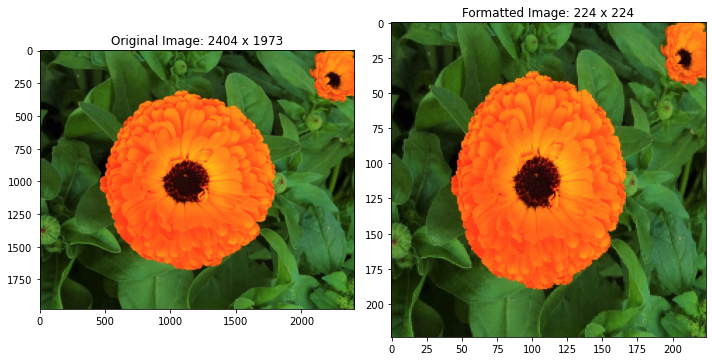

In [ ]:
# load in an image from test folder
imageURL = "model_test_images/marigold.jpg"
image = PIL.Image.open(imageURL)
testImage = np.asarray(image)

# format the image into correct size and dimensions
formattedImage = formatImage(image)

# display the original and formatted image
figure, (axis1, axis2) = plt.subplots(figsize=(10,10), ncols=2)
axis1.imshow(testImage)
axis1.set_title("Original Image: " + str(len(testImage[0])) + " x " + str(len(testImage)))
axis2.imshow(formattedImage)
axis2.set_title("Formatted Image: " + str(len(formattedImage[0])) + " x " + str(len(formattedImage)))
plt.tight_layout()
plt.show()

In [ ]:
# function to predict the label for a given image
def predict(imageURL, model, top_k):
  image = PIL.Image.open(imageURL)
  image = np.asarray(image)
  image = formatImage(image)
  prediction = model.predict(np.expand_dims(image, axis=0))
  topValues, topIndices = tf.math.top_k(prediction, top_k)

  # display the top k (3) probabilities for a given image
  print("The highest probabilities are:", topValues.numpy()[0])
  topClasses = [classLabels[str(val)] for val in topIndices.cpu().numpy()[0]]
  print("For the following classes:", topClasses)
  return topValues.numpy()[0], topClasses

The highest probabilities are: [9.9775487e-01 1.6610163e-03 3.3063776e-04]
For the following classes: ['hibiscus', 'hippeastrum', 'bougainvillea']


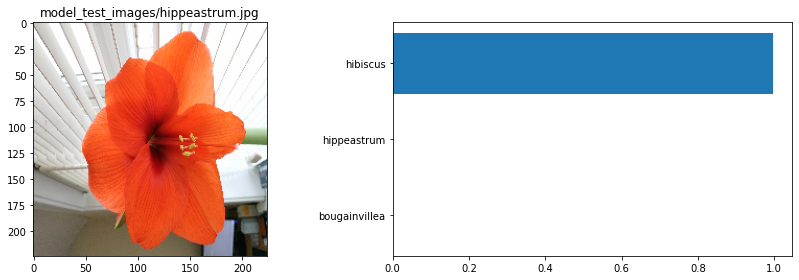

The highest probabilities are: [0.82285357 0.17369902 0.00342684]
For the following classes: ['primula', 'camellia', 'hard-leaved pocket orchid']


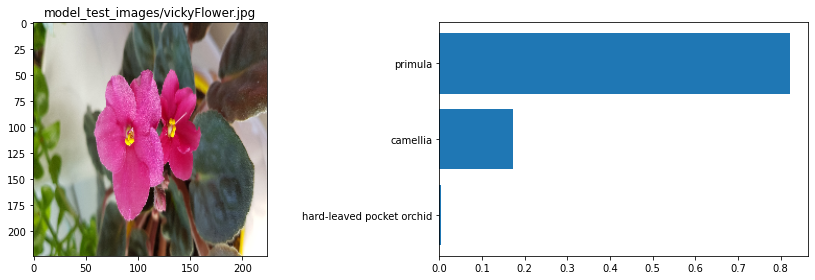

The highest probabilities are: [1.0000000e+00 1.3058522e-10 1.4001787e-14]
For the following classes: ['sweet pea', 'foxglove', 'bougainvillea']


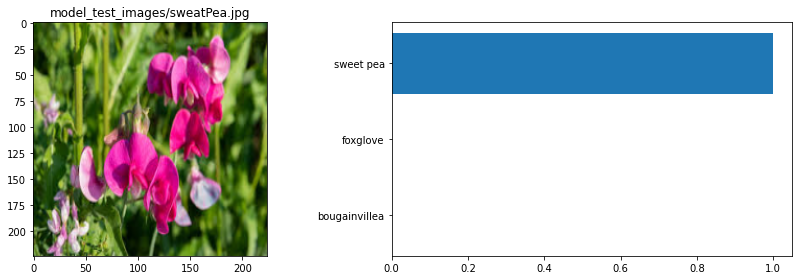

The highest probabilities are: [1.0000000e+00 1.6643104e-15 1.5482092e-16]
For the following classes: ['common dandelion', 'english marigold', 'spear thistle']


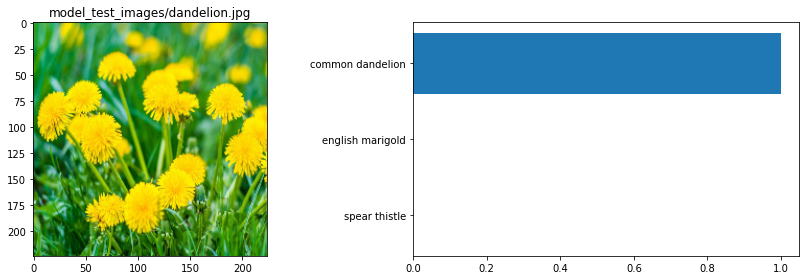

The highest probabilities are: [1.0000000e+00 1.4582558e-19 5.0536257e-22]
For the following classes: ['primula', 'trumpet creeper', 'pink-yellow dahlia']


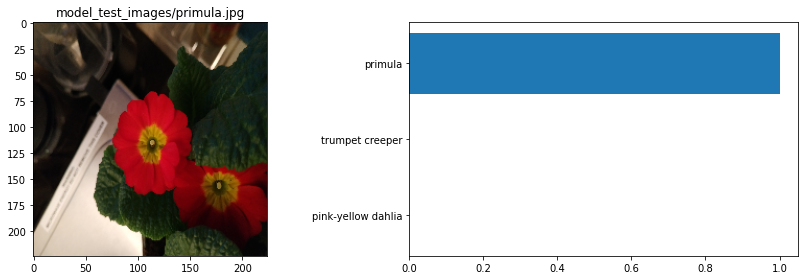

The highest probabilities are: [1.0000000e+00 8.4603540e-23 2.1111865e-29]
For the following classes: ['sweet william', 'carnation', 'tree mallow']


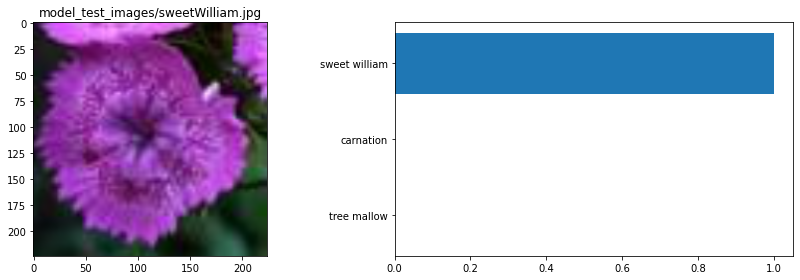

The highest probabilities are: [9.9854493e-01 1.4520569e-03 2.6445393e-06]
For the following classes: ['garden phlox', 'sweet william', 'foxglove']


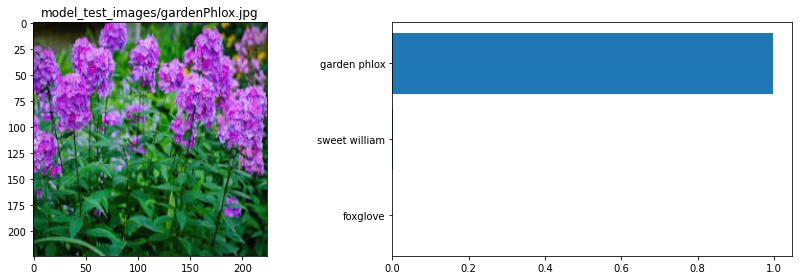

The highest probabilities are: [1.0000000e+00 1.5658875e-21 1.2165801e-25]
For the following classes: ['rose', 'camellia', 'corn poppy']


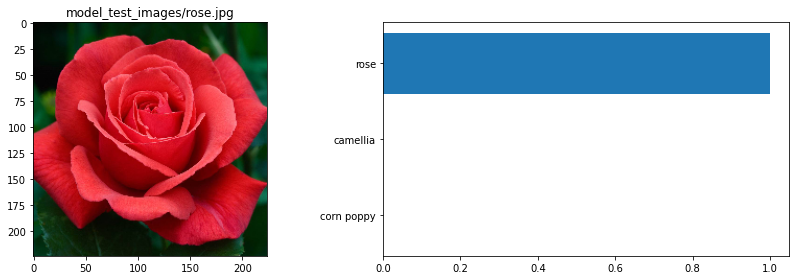

The highest probabilities are: [1.0000000e+00 2.4517748e-08 6.1531100e-11]
For the following classes: ['siam tulip', 'foxglove', 'sweet pea']


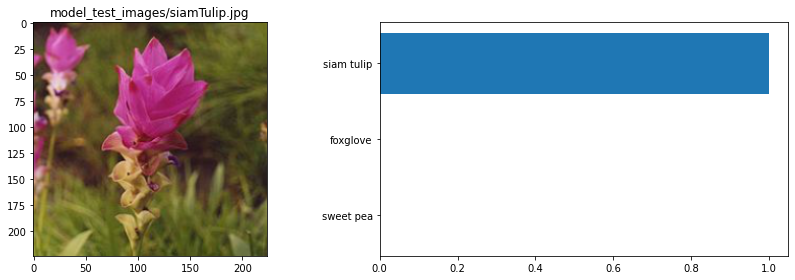

The highest probabilities are: [1.0000000e+00 9.5008734e-17 1.3933428e-25]
For the following classes: ['carnation', 'sweet william', 'marigold']


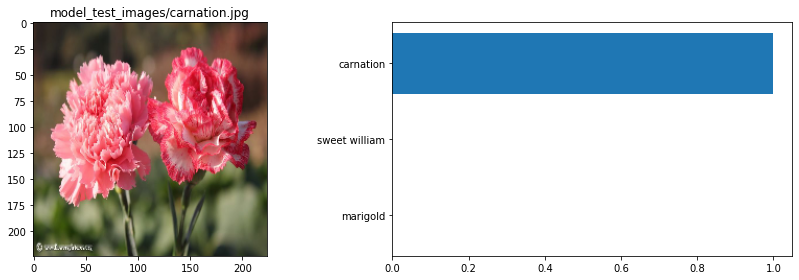

The highest probabilities are: [9.9999881e-01 1.2287848e-06 2.0092461e-09]
For the following classes: ['english marigold', 'marigold', 'bolero deep blue']


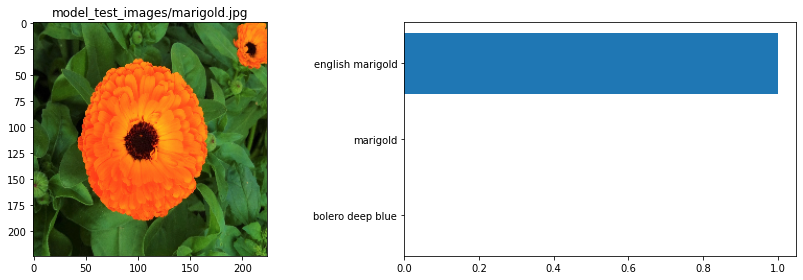

The highest probabilities are: [9.9958724e-01 4.1238731e-04 3.7475007e-07]
For the following classes: ['prince of wales feathers', 'snapdragon', 'globe thistle']


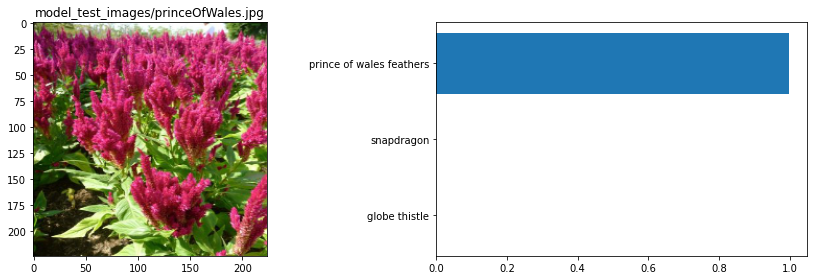

In [ ]:
# read in all images for testing, and predict their labels with custom model
imageFolder = glob.glob("model_test_images/*.jpg")
#for imageURL in imageFolder:
#  image = PIL.Image.open(imageURL)
#  image = np.asarray(image)
#  image = formatImage(image)
#  probabilities, predictions = predict(imageURL, customModel, 3)

#  # display images with their predicted labels
#  figure, (axis1, axis2) = plt.subplots(figsize=(12,4), ncols=2)
#  axis1.set_title(imageURL)
#  axis1.imshow(image)
#  axis2 = plt.barh(predictions[::-1], probabilities[::-1])
#  plt.tight_layout()
#  plt.show()

# read in all images for testing, and predict their labels with transfer learning model
for imageURL in imageFolder:
  image = PIL.Image.open(imageURL)
  image = np.asarray(image)
  image = formatImage(image)
  probabilities, predictions = predict(imageURL, transferLearningModel, 3)

  # display images with their predicted labels
  figure, (axis1, axis2) = plt.subplots(figsize=(12,4), ncols=2)
  axis1.set_title(imageURL)
  axis1.imshow(image)
  axis2 = plt.barh(predictions[::-1], probabilities[::-1])
  plt.tight_layout()
  plt.show()